In [1]:
%%html
<style>
    .dothis{
    font-weight: bold;
    color: #ff7f0e;
    font-size:large
    }
</style>

# Glacier mapping by means of band math

*****

This notebook demonstrates how we can use Python to do the same glacier mapping that we earlier carried out in QGIS.

There are several points at which you will need to modify a line of code. These are identified by <span class='dothis'>bold orange text</span>.


### Reading the data

We start with a few preparation such as reading all the packages we use in the processing.

In [2]:
# Make sure the script is using the proper kernel
try:
    %run ../swiss_utils/assert_env.py
except:
    %run ./swiss_utils/assert_env.py

In [3]:
# Import modules

# reload module before executing code
%load_ext autoreload
%autoreload 2

# define modules locations (you might have to adapt define_mod_locs.py)
%run ./swiss_utils/define_mod_locs.py

# to plot figures
%matplotlib inline

# import full general libraries

# import general libraries and allocate them a specific name
import time
import rioxarray
import xarray as xr
import numpy as np # np.average
import pandas as pd # DataFrame
import matplotlib.pyplot as plt

# import specific functions from general libraries
from datetime import datetime
from IPython.display import Image, display, HTML
from matplotlib import colors

# import dedicated function of general libraries

# import ODC (default) functions
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
from utils.data_cube_utilities.dc_utilities import write_png_from_xr
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

# import SDC functions
from swiss_utils.data_cube_utilities.sdc_utilities import ls_qa_clean, load_multi_clean, \
                                                          write_geotiff_from_xr, time_list
from swiss_utils.data_cube_utilities.sdc_advutils import oneband_fig, composite_fig

# connect to DC
import datacube
dc = datacube.Datacube()

# silence warning (not recommended during development)
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Change the size of the figures displayed in the notebooks: units are inches, order is (width, height).
plt.rcParams['figure.figsize'] = (16,8)      

**The next cell contains the dataset configuration information, which we have already made for you using the [config_tool](config_tool.ipynb) notebook. This ensures that you will have data well suited to map glacier extent.**

**To make this notebook run you will need to use anyone of Landsat or Sentinel 2 products with the red green and blue bands, as well as at least one swir band.**

In [5]:
# %load config_cell.txt
# Configuration

product = 'ls8_lasrc_swiss'
measurements = ['blue', 'green', 'nir', 'pixel_qa', 'red', 'swir1', 'swir2']

min_lon = 7.73228
max_lon = 7.957461
min_lat = 45.877007
max_lat = 46.022142

start_date = datetime.strptime('2016-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2016-09-30', '%Y-%m-%d')


****

__In the following we are using `dc.load()` to load the data. In contrast to `load_multi_clean()`, typically used in the other examples, 
this function does not mask any cloud covered areas.__

We are using `dc.load()` because the cloud masking does not work in the mountains where snow and ice get confused with clouds. 

**However, this means we now have to look at the scenes and manually decide which ones are cloud free.**

****

**If you see an error message when running the cell below, try running the configuration cell above again**

In [6]:
dataset_in = dc.load(product = product,
                     time = (start_date, end_date), 
                     lon = (min_lon, max_lon), 
                     lat = (min_lat,max_lat),
                     measurements = measurements)
dataset_in

<xarray.Dataset>
Dimensions:      (time: 7, latitude: 426, longitude: 662)
Coordinates:
  * time         (time) datetime64[ns] 2016-08-09T10:10:45 ... 2016-09-26T10:...
  * latitude     (latitude) float64 46.02 46.02 46.02 ... 45.88 45.88 45.88
  * longitude    (longitude) float64 7.732 7.733 7.733 ... 7.957 7.957 7.958
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) int16 -9999 -9999 -9999 ... 583 836
    green        (time, latitude, longitude) int16 -9999 -9999 ... 1151 1404
    nir          (time, latitude, longitude) int16 -9999 -9999 ... 4855 4599
    pixel_qa     (time, latitude, longitude) int32 1 1 1 1 1 ... 322 322 322 322
    red          (time, latitude, longitude) int16 -9999 -9999 ... 1246 1507
    swir1        (time, latitude, longitude) int16 -9999 -9999 ... 3846 4056
    swir2        (time, latitude, longitude) int16 -9999 -9999 ... 2217 2643
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

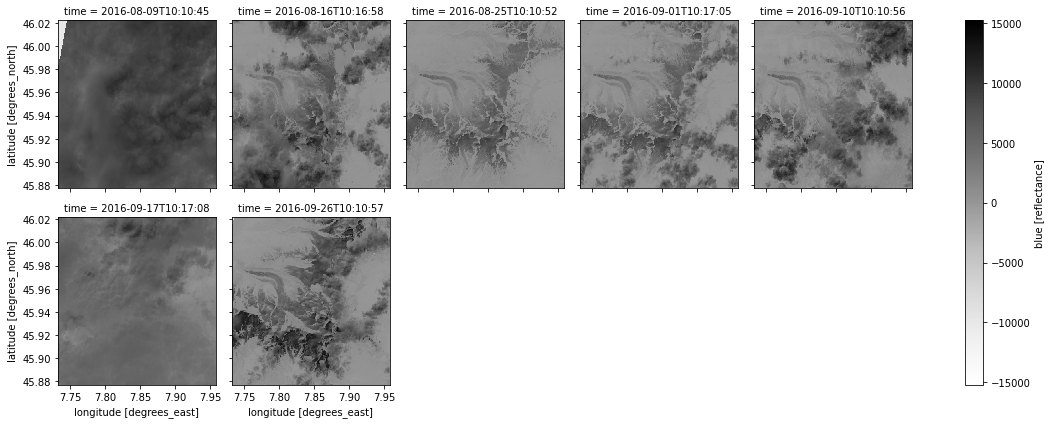

In [7]:
# plot the xarray.Dataset to get an overview of the different scenes along the time axis
dataset_in.blue.plot(col='time', col_wrap=5, cmap='Greys')

### Selecting a cloud free scene

As mentioned before, we have used the `dc.load()` function which does not mask cloud covered areas. 

<span class='dothis'>We now have to plot all time steps again and then visually define which of the scenes is cloud free.</span>

This is best done by visualizing composites, either true color or false color. In the following we first visualize the data in true color, followed by two examples of popular false color visualization for Landsat data.

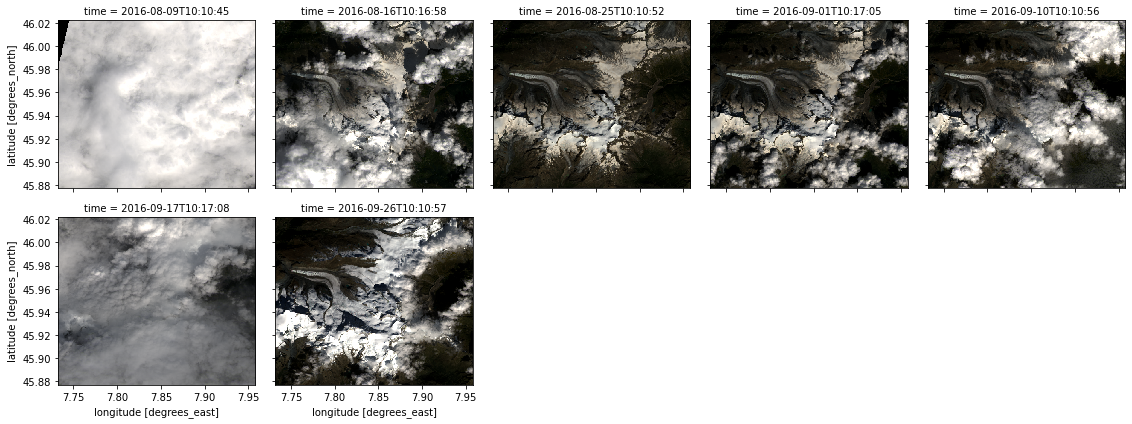

In [8]:
# Let's plot composites in True color (red, green, blue)
# robust=True guesses the minimum and maximum values for each image.
dataset_in[['red','green','blue']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

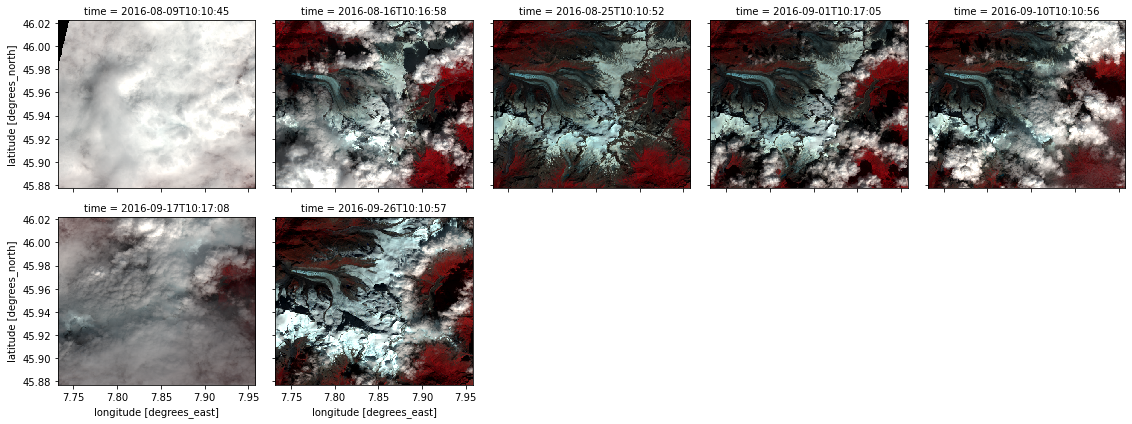

In [9]:
# Let's plot composites in False color (nir, red, green)
dataset_in[['nir','red', 'green']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

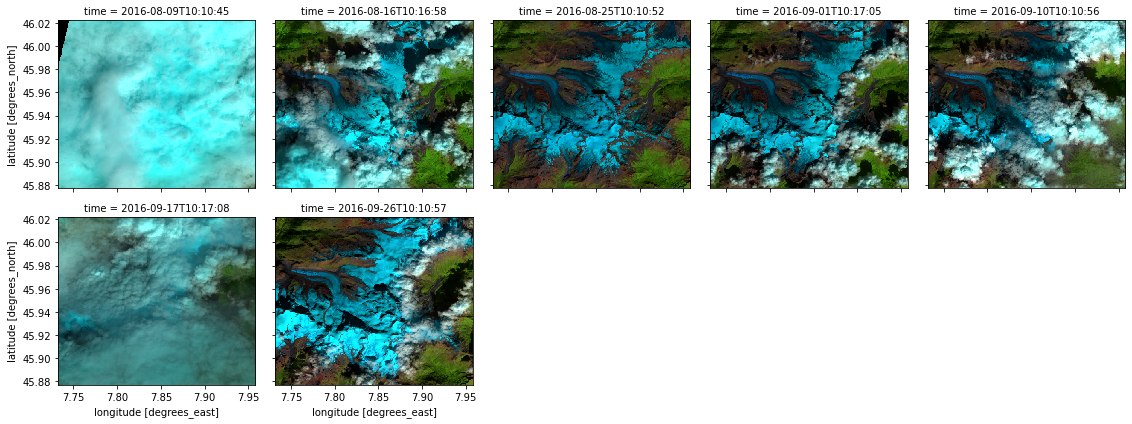

In [10]:
# Let's plot composites in another false color combination, this time (swir1, nir, red) which is well suited to see ice and snow
dataset_in[['swir1','nir', 'red']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

Regardless of which visualization we work with, we see that from the seven scenes, only one appears cloud free: **2016-08-25T10:17:05**. We continue working only with that scene.

In [11]:
# Let's select the image we are interested in and save it to a new variable.
# To do this we provide the date of the image we selected above 
# The squeeze() command removes the time dimension from the DataArray, so you are left with two dimensions: latitude and longitude.
mosaic = dataset_in.sel(time='2016-08-25').squeeze()
mosaic

<xarray.Dataset>
Dimensions:      (latitude: 426, longitude: 662)
Coordinates:
    time         datetime64[ns] 2016-08-25T10:10:52
  * latitude     (latitude) float64 46.02 46.02 46.02 ... 45.88 45.88 45.88
  * longitude    (longitude) float64 7.732 7.733 7.733 ... 7.957 7.957 7.958
    spatial_ref  int32 4326
Data variables:
    blue         (latitude, longitude) int16 -9999 -9999 -9999 ... 537 495 755
    green        (latitude, longitude) int16 -9999 -9999 -9999 ... 1012 1262
    nir          (latitude, longitude) int16 -9999 -9999 -9999 ... 4903 4415
    pixel_qa     (latitude, longitude) int32 1 1 1 1 322 ... 322 322 322 322 322
    red          (latitude, longitude) int16 -9999 -9999 -9999 ... 1066 1359
    swir1        (latitude, longitude) int16 -9999 -9999 -9999 ... 3352 3619
    swir2        (latitude, longitude) int16 -9999 -9999 -9999 ... 1892 2373
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

<a id='mosaic_plot'> </a>
Plot mosaic the default way.

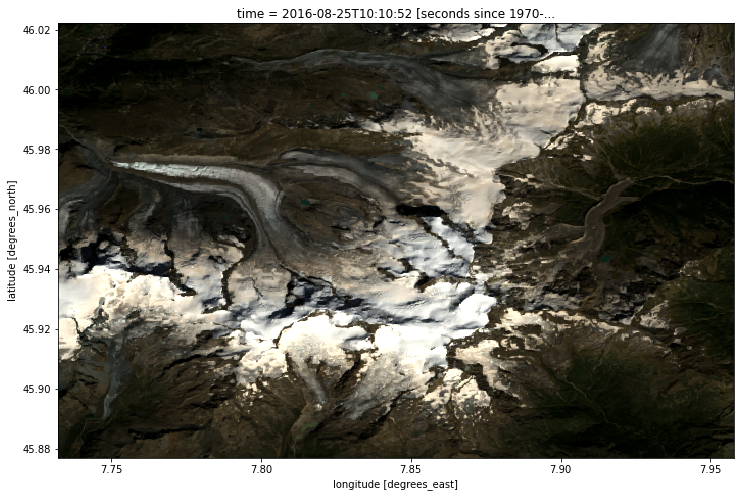

In [12]:

# To do this we need to provide the list of bands we are interested in.
mosaic[['red','green','blue']].to_array().plot.imshow(robust=True)
plt.gca().set_aspect('equal')

In [13]:
# Export the red, green and blue bands of the image (might become usefuly later)
write_geotiff_from_xr(tif_path = 'glaciers.tif',
                      dataset = mosaic[['red','green','blue']].astype('int16'),
                      crs=dataset_in.crs,
                      compr = 'DEFLATE')


### Band math for glacier detection

*****

We now detect glacier surfaces using the band math: *G = Red / Swir*

Thereby a threshold needs to be defined to distinguish glaciers from non-glacierized terrain.

In [14]:
G = mosaic.red / mosaic.swir1

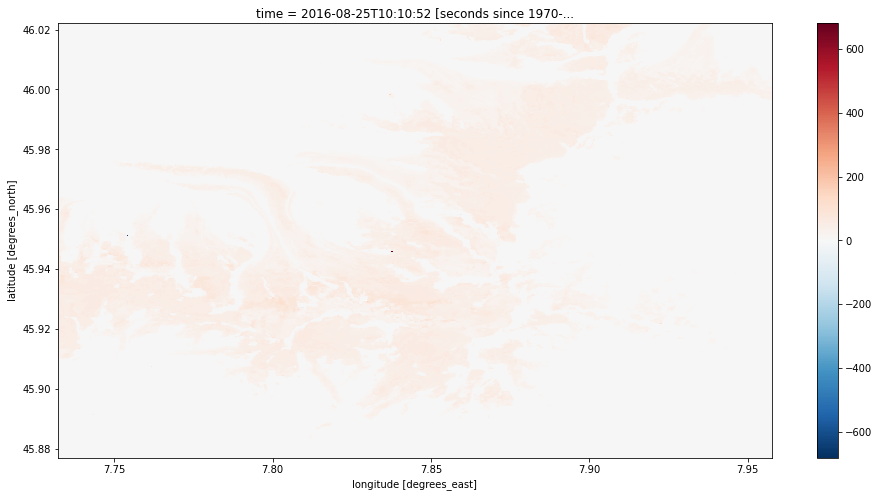

In [15]:
G.plot()

We can faintly recognize the result but the extent of the automatically generated scale is not good. 

Probably, there are outliers which result in the automated choice of the data range. 

The easy way to visualize the data while ignoring the outliers is to pass the parameter robust=True. This will use the 2nd and 98th percentiles of the data to compute the color limits.

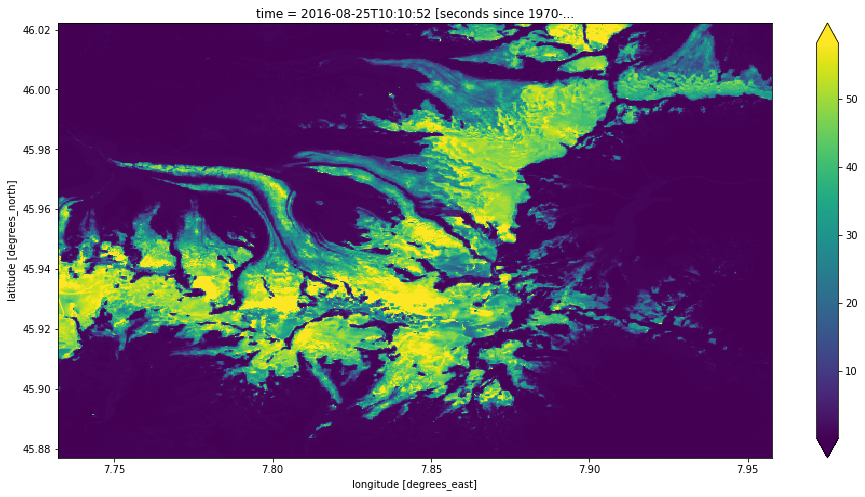

In [16]:
G.plot(robust=True)

**Note how the color palette has changed.** This is simply because the `DataArray.plot()` function we are using tries to automatically define the optimal colormap. 

We can suppress this behaviour by specifying a colormap from https://matplotlib.org/stable/gallery/color/colormap_reference.html

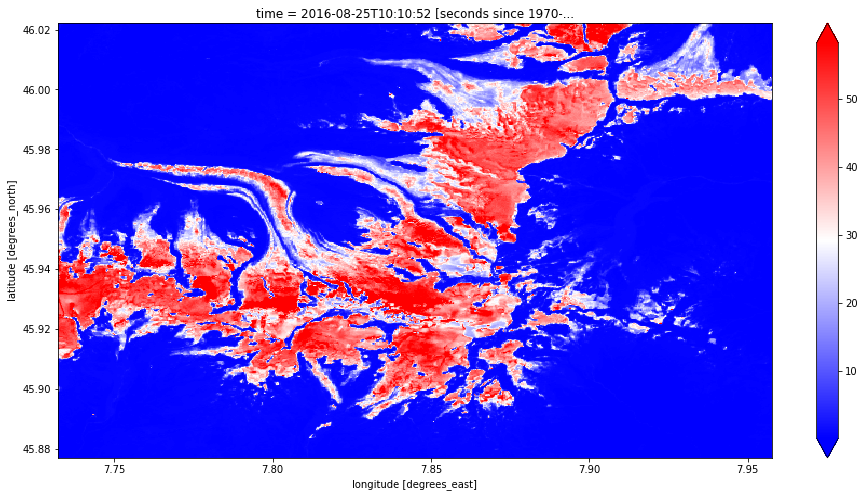

In [17]:
G.plot(robust=True, cmap='bwr')

Now let's try to plot the data as a histogram

ValueError: supplied range of [-618.8, inf] is not finite

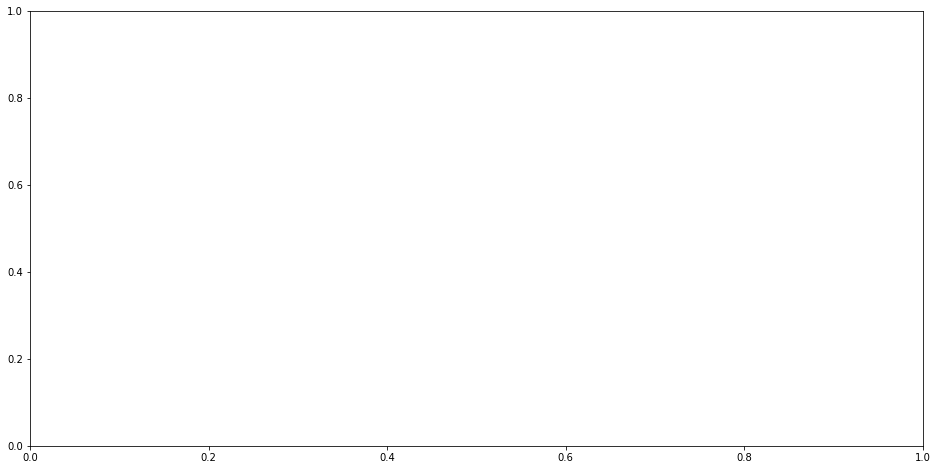

In [18]:
G.plot.hist()

This throws an error message, telling us that the data range reaches infinity. This might also explain some of our difficulties in plotting. 

<span class='dothis'>Let's address the problem by the root and remove all cells that have the value "infinte" and then try to plot the histogram again.</span>

In [19]:
G = G.where(np.isfinite(G))  # Set all values that are not finite to NaN (Not a Number)

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.21242e+05,
        6.07650e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-618.8       , -488.75333333, -358.70666667, -228.66      ,
         -98.61333333,   31.43333333,  161.48      ,  291.52666667,
         421.57333333,  551.62      ,  681.66666667]),
 <BarContainer object of 10 artists>)

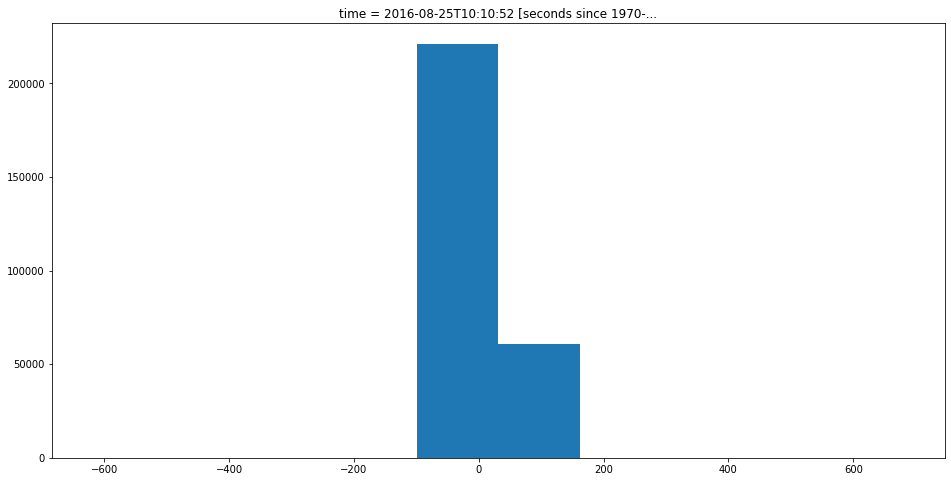

In [20]:
G.plot.hist()

This works now but the results are not satisfying as we can't recognize any details. We know that the threshold is somewhere close to zero, so we would like to see the details in the vicinity of zero. 

* Let's look at the range of values in G
* Let's increase the number of bins in the histogram

(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.40000e+01,
        1.77588e+05, 7.20300e+03, 4.01000e+03, 3.17000e+03, 2.76000e+03,
        2.65200e+03, 2.91700e+03, 3.21200e+03, 3.53100e+03, 3.77100e+03,
        3.82300e+03, 4.07000e+03, 4.27500e+03, 4.48800e+03, 4.83400e+03,
        5.30900e+03, 5.99100e+03, 6.54200e+03, 6.61900e+03, 6.62200e+03]),
 array([-50. , -47.5, -45. , -42.5, -40. , -37.5, -35. , -32.5, -30. ,
        -27.5, -25. , -22.5, -20. , -17.5, -15. , -12.5, -10. ,  -7.5,
         -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,
         17.5,  20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,
         40. ,  42.5,  45. ,  47.5,  50. ]),
 <BarContainer object of 40 artists>)

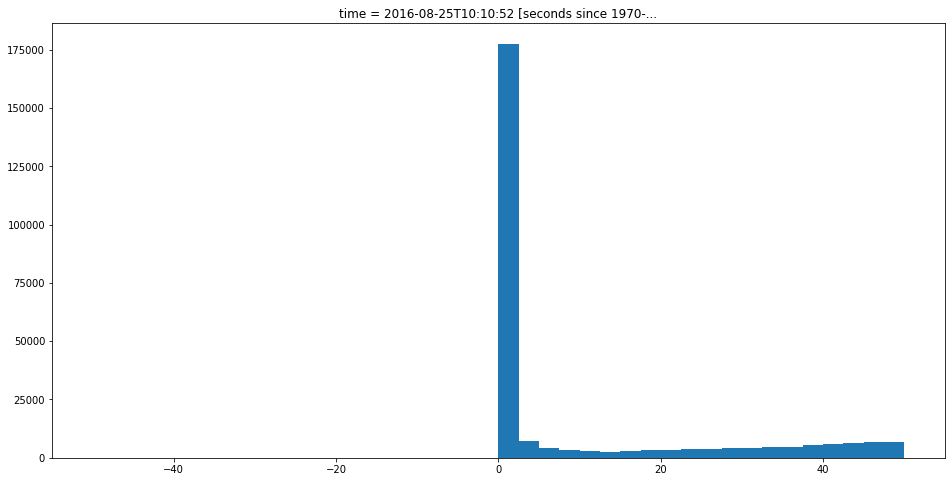

In [26]:
G.where((G > -50) | (G < 50)).plot.hist(bins=40, range=(-50, 50))  # We added the "bin" keyword that allows specifying the number of bins to be used

This looks even better, but there is no need to visualize all the absence of data on the left-hand side. <span class='dothis'>Adjust the parameters in the plotting command above so you achieve an optimal visualization.</span>

### Selecting the threshold value for glacier mapping

Now to the actual glacier mapping. <span class='dothis'>As we did in QGIS, we will define a threshold to distinguish between glaciers (where <i>G > threshold</i>) and non-glacierized terrain (<i>G < threshold</i>).</span>

We can directly test whether the threshold is appropriate by plotting the scene, but this time telling the program to use discrete colors for all values that are within intervals that we define with the `levels` keyword. Note that we need to define at least two values for `levels`. We simply chose the first one very low, outside the range of data values.



In [27]:
# here we set the threshold - CHANGE THIS TO VARY THE THRESHOLD!
threshold = 0  

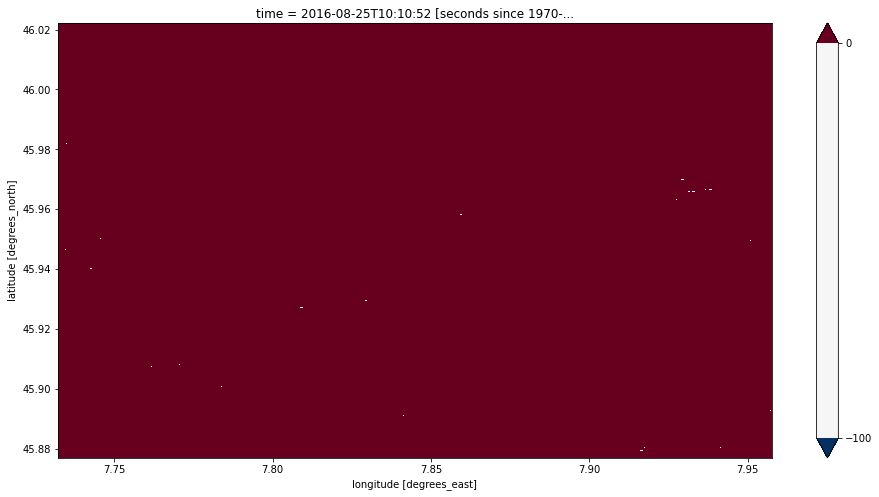

In [28]:
# Using the "levels" keyword which allows specifying the boundaries between discrete classes for plotting. 
G.plot(levels=[-100, threshold])  # Here the resulting classes are (1) smaller -100, (2) between -100 and "threshold", (3) larger than "Trheshold"

This plot now shows all grid cell with values between -100 and "threshold" in white, all grid cells with values > threshold in red.

This is excellent, **but has the disadvantage that we have no comparison with the original scene, to be able to assess how accurately our chosen threshold distinguishes glaciers from non-glacierized terrain.**

We thus go more fancy and **plot the above threshold map *and* a false color composite of the original scene on top of each other.** We do this by simply calling the `plot()` function twice, the two graphics will then be plotted into the same figure. Furthermore, we use the `alpha` parameter to define how transparent the threshold map should be (`alpha = 0` fully transparent, `alpha = 1` fully opaque).

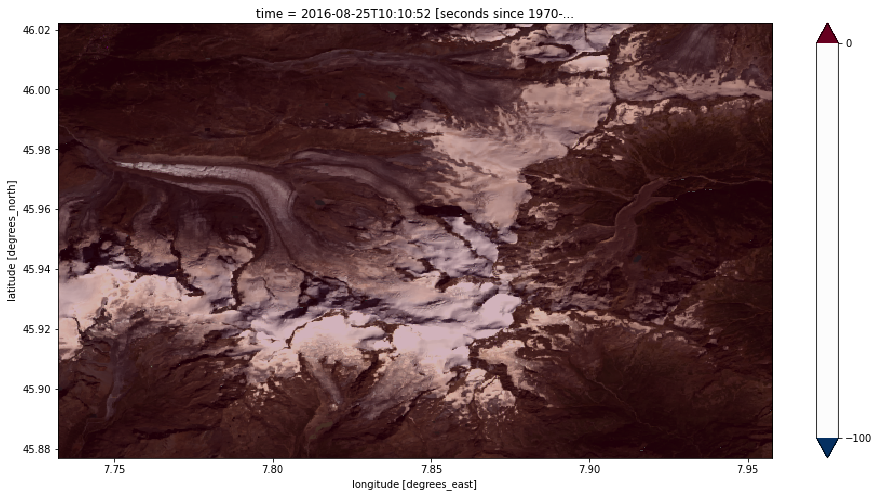

In [29]:
G.plot(levels=[-100, threshold], alpha=0.3)
mosaic[['red','green','blue']].to_array().plot.imshow(robust=True)

With these tools at hand, **vary the threshold to find an optimal treshold value.**

### Basic statistics

**Now to some very basic statistics: How many percent of the chosen satellite image are glacier covered?**

We calculate this by taking the number of glacierized grid cells `(G.where(G > threshold)).count()` and divide them by the total number of grid cells `G.count()`. The result is again a xr.DataArray which contains just the value.

In [30]:
100 * (G.where(G > threshold)).count() / G.count()

<xarray.DataArray ()>
array(99.98900748)
Coordinates:
    time         datetime64[ns] 2016-08-25T10:10:52
    spatial_ref  int32 4326

### Export the results

After we found an optimal threshold value, let's now create an array where all glacier grid cells have the value 1, and all non-glacierized cells have the value 0.

We do this by using the `xr.where()` function. Its syntax is `xr.where(condition, value to use where condition is True, value to use where condition is False)`.

In [31]:
G

<xarray.DataArray (latitude: 426, longitude: 662)>
array([[1.        , 1.        , 1.        , ..., 0.40078408, 0.39327181,
        0.3557047 ],
       [1.        , 1.        , 1.        , ..., 0.37957087, 0.3481329 ,
        0.31919573],
       [1.        , 1.        , 1.        , ..., 0.35395506, 0.35987749,
        0.29776592],
       ...,
       [0.27580772, 0.27580772, 0.26879371, ..., 0.37364532, 0.36889557,
        0.37122417],
       [0.28989977, 0.28146789, 0.25882353, ..., 0.37346739, 0.35973764,
        0.37431623],
       [0.29413974, 0.27961381, 0.26525631, ..., 0.32047911, 0.31801909,
        0.3755181 ]])
Coordinates:
    time         datetime64[ns] 2016-08-25T10:10:52
  * latitude     (latitude) float64 46.02 46.02 46.02 ... 45.88 45.88 45.88
  * longitude    (longitude) float64 7.732 7.733 7.733 ... 7.957 7.957 7.958
    spatial_ref  int32 4326

In [32]:
glacier = xr.where(G > threshold, 1, 0)
glacier

<xarray.DataArray (latitude: 426, longitude: 662)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
    time         datetime64[ns] 2016-08-25T10:10:52
  * latitude     (latitude) float64 46.02 46.02 46.02 ... 45.88 45.88 45.88
  * longitude    (longitude) float64 7.732 7.733 7.733 ... 7.957 7.957 7.958
    spatial_ref  int32 4326

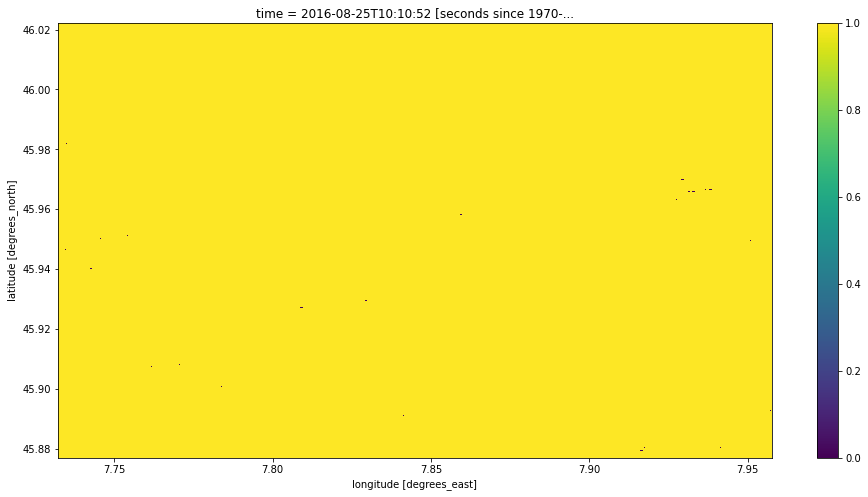

In [33]:
glacier.plot()  # plt it once again to see whether the result is what we want

<span class='dothis'>If everything looks fine, then it is now time to export our glacier map. We do this by using the function `rio.to_raster()`.</span>

Note that our xr.DataArray named *glacier* is of the data type `int64` (= 64 bit integer). The export function cannot handle this data type. Thus we convert *glacier* to data type `int16` (16 bit integer) during export by using `glacier.astype('int16')`.

In [34]:
# Export of the glacier map (which is an xarray.DataArray)

glacier.astype('int16').rio.to_raster("glacier_map.tif")

# Note: the xr.DataArray named "glacier" is of a data type (int64 or 64 bit integer) that the export function

*****

# Reprojection

*****

All the operations above we carried out using a CRS (coordinate reference system) of latitude and longitude called WGS84 (its code is *EPSG:4326*). You might have noticed that this CRS is displaying things with units of latitude and longitude. The images look compressed in the latitude dimension. Below is an example how you can reproject the data to CH1903+ / LV95 (EPSG:2056), also known as "SwissGrid".


In [35]:
# By default lat and lon use EPSG:4326 which is the CRS used to store SDC data.
# Let's reproject the xarray.Dataset into (in our case Swiss CRS) CH1903+ / LV95 (EPSG:2056).
dataset_CH = dataset_in.rio.set_crs("epsg:4326").rio.reproject("epsg:2056")

# xarray.Dataset CRS metadata remains in previous CRS
# let's update metadata
dataset_CH.attrs['crs'] = 'EPSG:2056'
dataset_CH

<xarray.Dataset>
Dimensions:      (x: 581, y: 537, time: 7)
Coordinates:
  * x            (x) float64 2.623e+06 2.623e+06 2.623e+06 ... 2.64e+06 2.64e+06
  * y            (y) float64 1.097e+06 1.097e+06 ... 1.081e+06 1.081e+06
  * time         (time) datetime64[ns] 2016-08-09T10:10:45 ... 2016-09-26T10:...
    spatial_ref  int64 0
Data variables:
    blue         (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    green        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    nir          (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    pixel_qa     (time, y, x) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    red          (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir2        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:           EPSG:2056
    grid_mapping:  spatial_ref

Note how the dimensions have changed from `latitude, longitude, time` to `x, y, time`.

Plot the mosaic again. We will see that the coordinate axes have changed and now represent the familiar Swissgrid. <span class='dothis'>Compare it</span> to the lat/lon image we made earlier in this notebook <a href='#mosaic_plot'>(click here to be taken to it)</a> .

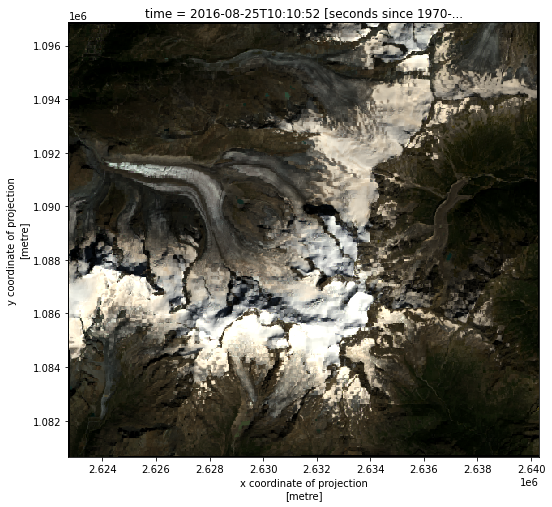

In [36]:
# Plot mosaic again
plt.figure()
ax = plt.subplot(111, aspect='equal')
p = dataset_CH[['red','green','blue']].isel(time=2).to_array().plot.imshow(robust=True)
# Make the x and y coordinates equally spaced.
plt.gca().set_aspect('equal')

In [37]:
dataset_CH

<xarray.Dataset>
Dimensions:      (x: 581, y: 537, time: 7)
Coordinates:
  * x            (x) float64 2.623e+06 2.623e+06 2.623e+06 ... 2.64e+06 2.64e+06
  * y            (y) float64 1.097e+06 1.097e+06 ... 1.081e+06 1.081e+06
  * time         (time) datetime64[ns] 2016-08-09T10:10:45 ... 2016-09-26T10:...
    spatial_ref  int64 0
Data variables:
    blue         (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    green        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    nir          (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    pixel_qa     (time, y, x) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    red          (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir2        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:           EPSG:2056
    grid_mapping:  spatial_ref

**Note how the coordinate units have changed from degrees to metres, compared to the previous plots.**

You cannot use the `write_geotiff_from_xr()` function to export datasets that are in SwissGrid, it will cause an error. Use instead the `rio.to_raster()` function which we used already earlier.

In [38]:
dataset_CH[['nir','red', 'green']].isel(time=2).to_array().astype('int16').rio.to_raster("glacier_CH_false_color.tif")